In [35]:
###########################################################
### step  3 - training and prediction
# 
# Author: André V. Silva 2021-01-02
###########################################################

import time
from datetime import datetime

start_time = time.time()

# libraries for this project
import json
import pandas as pd
import numpy as np
from numpy import mean, std
from IPython.display import HTML
import matplotlib.pyplot as plt
from icecream import ic
#import seaborn as sns
import os.path
import sys
import gc
import feather
from icecream import ic
from sys import getsizeof
import time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from matplotlib import pyplot
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

import warnings

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

import mlflow
import mlflow.sklearn

k_features = 6

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

# This make machine learning interpretable and understandable to everyone.
# fshapashrom shapash.explainer.smart_explainer import SmartExplainer 

# Pandas has a high consume of memory RAM usage
# release memory RAM
def release_memory(df):   
    del df
    gc.collect() 
    df = pd.DataFrame() # point to NULL
    print('memory RAM released.')

# Get start time 
start_time = time.time()

def transf_cat_num(df):

    print("preprocessing: the categorical and numerical feature now...")
    categorical_feature_names = list(df.select_dtypes(include='category').columns)
    numeric_feature_names = list(df.drop(categorical_feature_names, axis=1).columns)
    
    print("One Hot Encoder...")
    print(f'categorical features: {categorical_feature_names}')
    
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))] )
    
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                        ('scaler', StandardScaler())])

    # Two preprocessed steps together using the Column Transformer module
    preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_feature_names),
                  ('cat', categorical_transformer, categorical_feature_names)])
    
    return preprocessor


# Get start time 
start_time = time.time()

# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print(">>> date: ", dt_string)

>>> date:  03/09/2021 19:08:12


In [36]:
print("Loading dataset - to modeling...")

# loading data feather format
df = pd.read_feather('dataset_featureselect.ftr')

print(df)
print(df.dtypes)

# Alternatively X and y can be obtained directly from the dataframe attribute:
X = df.drop('median_house_value', axis=1) # drop the column target
y = df['median_house_value'] # target

Loading dataset - to modeling...
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20428    -121.09     39.48                25.0       1665.0           374.0   
20429    -121.21     39.49                18.0        697.0           150.0   
20430    -121.22     39.43                17.0       2254.0           485.0   
20431    -121.32     39.43                18.0       1860.0           409.0   
20432    -121.24     39.37                16.0       2785.0           616.0   

       population 

In [37]:
## Pipeline
def pipeline_project(df, model):
    # Pipeline object
    print("setting the pipeline object ...")
    print('preprocessor...')
    preprocessor = transf_cat_num(df)

    feature_selection = SelectKBest(score_func=mutual_info_regression, k = 5) # f_regression

    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('fs', feature_selection),
                            ('scaler', StandardScaler()),
                            ('model', model)])

    print('>>> pipeline defined!')    
    return pipe

In [38]:
# Regression models
def get_models():
  models['RandomForest']=RandomForestRegressor(n_estimators=5, random_state = 42, n_jobs = -1)
  models['DecisionTree']=DecisionTreeRegressor()
  #models['KNR']=KNeighborsRegressor()
  models['XGBoost']=xgb.XGBRegressor(objective="reg:linear", random_state=42)
  models['CatBoost'] = cb.CatBoostRegressor(loss_function='RMSE')
  models['LinearR']= LinearRegression(n_jobs = -1) # Use all computer cores

  return models

In [39]:
models = dict()
models = get_models()

print(models)

{'RandomForest': RandomForestRegressor(n_estimators=5, n_jobs=-1, random_state=42), 'DecisionTree': DecisionTreeRegressor(), 'XGBoost': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', random_state=42, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=None, verbosity=None), 'CatBoost': <catboost.core.CatBoostRegressor object at 0x7f1c40372400>, 'LinearR': LinearRegression(n_jobs=-1)}


setting the pipeline object ...
preprocessor...
preprocessing: the categorical and numerical feature now...
One Hot Encoder...
categorical features: ['ocean_proximity']
>>> pipeline defined!
prediction...
>RandomForest 0.810 (0.000)
memory RAM released.
memory RAM released.
setting the pipeline object ...
preprocessor...
preprocessing: the categorical and numerical feature now...
One Hot Encoder...
categorical features: ['ocean_proximity']
>>> pipeline defined!
prediction...
>DecisionTree 0.712 (0.000)
memory RAM released.
memory RAM released.
setting the pipeline object ...
preprocessor...
preprocessing: the categorical and numerical feature now...
One Hot Encoder...
categorical features: ['ocean_proximity']
>>> pipeline defined!
[19:08:19] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
prediction...
>XGBoost 0.836 (0.000)
memory RAM released.
memory RAM released.
setting the pipeline object ...
preprocessor...
preprocessing

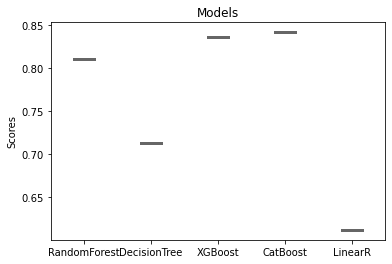

In [40]:
# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():
    
    # Alternatively X and y can be obtained directly from the dataframe attribute:
    X = df.drop('median_house_value', axis=1) # drop the column target
    y = df['median_house_value'] # target

    pipe = pipeline_project(X, model)

    ## Split-out validation dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.14, random_state=1)

    ## Training the model
    #print('training the model...')

    ## Fitting...
    pipe.fit(X_train, y_train)

    ## prediction
    print('prediction...')
    y_pred = pipe.predict(X_test)

    scores = r2_score(y_test, y_pred)
    # store the results
    results.append(scores)

    ## model names
    names.append(name)
    
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

    release_memory(X)
    release_memory(y)

# plot model performance for comparison
sns.boxplot(x=names, y=results, palette="Set3", linewidth=3, width=0.3)
plt.title("Models")
plt.ylabel("Scores") # MAE -- Mean Absolute Error
#sns.xlabel("Models")
plt.savefig('figures/scores_models.png')
plt.savefig('figures/scores_importance_models.pdf')
plt.show()

In [41]:
feature_names =list(X.columns)

[0.16581896209736796, 0.16646571958658746, 0.511405209362698, 0.00866979853079018, 0.14764031042255654]
features selected:
the K best features selected to the model (RandomForest): ['longitude', 'latitude', 'median_income', 'ocean_proximity']
######################################################################
model: RandomForest
longitude.......: 16.58 %
latitude.......: 16.65 %
median_income.......: 51.14 %
ocean_proximity.......: 0.87 %


/home/andsilva/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


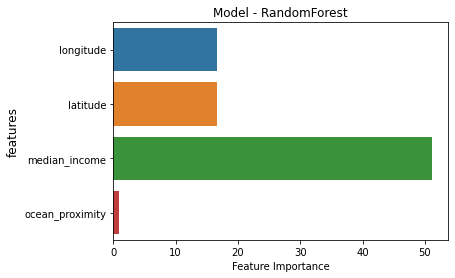

######################################################################
[0.1728950222509941, 0.1643286482621477, 0.5087801185084377, 0.007690612007369679, 0.14630559897105086]
features selected:
the K best features selected to the model (DecisionTree): ['longitude', 'latitude', 'median_income', 'ocean_proximity']
######################################################################
model: DecisionTree
longitude.......: 17.29 %
latitude.......: 16.43 %
median_income.......: 50.88 %
ocean_proximity.......: 0.77 %


/home/andsilva/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


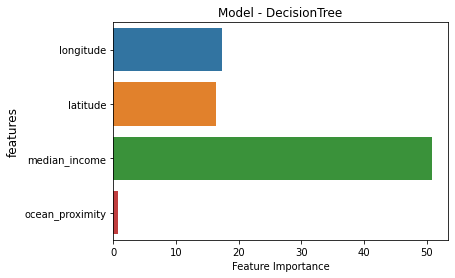

######################################################################
[0.020368561, 0.021457452, 0.07951609, 0.02226927, 0.8563886]
features selected:
the K best features selected to the model (XGBoost): ['longitude', 'latitude', 'median_income', 'ocean_proximity']
######################################################################
model: XGBoost
longitude.......: 2.04 %
latitude.......: 2.15 %
median_income.......: 7.95 %
ocean_proximity.......: 2.23 %


/home/andsilva/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


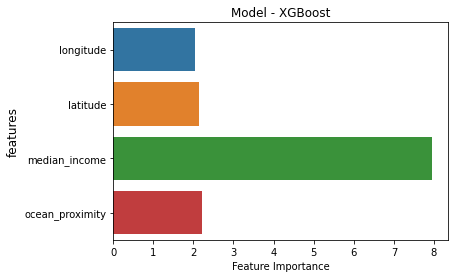

######################################################################
[28.904977143484412, 27.744153155842177, 25.00981367103331, 2.740801320048452, 15.600254709591653]
features selected:
the K best features selected to the model (CatBoost): ['longitude', 'latitude', 'median_income', 'ocean_proximity']
######################################################################
model: CatBoost
longitude.......: 28.9 %
latitude.......: 27.74 %
median_income.......: 25.01 %
ocean_proximity.......: 2.74 %


/home/andsilva/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


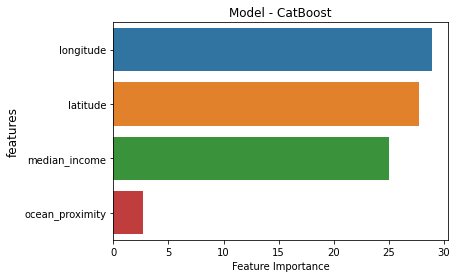

######################################################################


In [42]:
# feature importance
for name, model in models.items():

    if(name == 'LinearR'):
        continue

    list_feat_importances = list(model.feature_importances_)
    print(list_feat_importances)
    
    dict_feat_importances = {}

    print('features selected:')
    mask = pipe.named_steps['fs'].get_support()

    new_features = [] # The list of your K best features

    for bool, feature in zip(mask, feature_names):
        if(bool and (feature != 'p_esc_final')):
            new_features.append(feature)
            
    print(f'the K best features selected to the model ({name}): {new_features}')

    i=0

    print('######################################################################')
    print(f'model: {name}')

    # list of feature importances
    for ilist in new_features:

        if(name=='CatBoost'):
            dict_feat_importances[ilist] = list_feat_importances[i] # porcentagem %
            print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
            i=i+1
        else:
            dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
            print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
            i=i+1

    x_axis = list(dict_feat_importances.values())
    y_axis = list(dict_feat_importances.keys())

    sns.barplot(x_axis, y_axis)
    
    plt.ylabel('features', fontsize=12)
    plt.xlabel('Feature Importance')
    plt.title(f"Model - {name}")
    plt.savefig(f'figures/feature_importance_model_{name}.png')
    plt.savefig(f'figures/feature_importance_model_{name}.pdf')
    # Show graphic
    plt.show()


    print('######################################################################')

In [43]:
time_exec_min = round( (time.time() - start_time)/60, 4)
    
print(f'time of execution (total pipeline): {time_exec_min} minutes')
# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print(">>> date: ", dt_string)
print('Done! please, check the results. :)')

time of execution (total pipeline): 0.3343 minutes
>>> date:  03/09/2021 19:08:32
Done! please, check the results. :)
